In [180]:
import pandas as pd
import math
import re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [181]:
df = pd.read_csv('SMSSpamCollection.csv', header=None)

In [182]:
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [183]:
df.columns = ['label', 'message']

In [184]:
print(df.columns)

Index(['label', 'message'], dtype='object')


In [185]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})

In [186]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [187]:
train, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [188]:
def tokenize(text):
    text = text.lower()  
    text = re.sub(r"[^a-z0-9\s]", "", text)  
    return text.split()

In [189]:
train["tokens"] = train["message"].apply(tokenize)
test["tokens"]  = test["message"].apply(tokenize)

In [190]:
train.head()

,label,message,tokens
184,0,"He will, you guys close?","[he, will, you, guys, close]"
2171,0,CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER ...,"[can, i, please, come, up, now, imin, towndont..."
5422,0,Ok k..sry i knw 2 siva..tats y i askd..,"[ok, ksry, i, knw, 2, sivatats, y, i, askd]"
4113,0,"I'll see, but prolly yeah","[ill, see, but, prolly, yeah]"
4588,0,"I'll see if I can swing by in a bit, got some ...","[ill, see, if, i, can, swing, by, in, a, bit, ..."


In [191]:
test.head()

,label,message,tokens
2825,0,No need to buy lunch for me.. I eat maggi mee..,"[no, need, to, buy, lunch, for, me, i, eat, ma..."
3695,0,Ok im not sure what time i finish tomorrow but...,"[ok, im, not, sure, what, time, i, finish, tom..."
3904,0,Waiting in e car 4 my mum lor. U leh? Reach ho...,"[waiting, in, e, car, 4, my, mum, lor, u, leh,..."
576,1,"You have won ?1,000 cash or a ?2,000 prize! To...","[you, have, won, 1000, cash, or, a, 2000, priz..."
2899,0,If you r @ home then come down within 5 min,"[if, you, r, home, then, come, down, within, 5..."


In [192]:
all_words = Counter(w for toks in train["tokens"] for w in toks)
vocab = {w for w, c in all_words.items() if c >= 2}
vocab |= {"<s>", "</s>", "<u>"}

In [193]:
def build_counts(df_sub):
    bg, uw = defaultdict(float), defaultdict(float)
    for toks in df_sub["tokens"]:
        seq = ["<s>"] + [w if w in vocab else "<u>" for w in toks] + ["</s>"]
        for i in range(1, len(seq)):
            uw[seq[i-1]] += 1
            bg[(seq[i-1], seq[i])] += 1
    return bg, uw

In [194]:
bg_ham, uw_ham = build_counts(train[train["label"] == 0])
bg_spam, uw_spam = build_counts(train[train["label"] == 1])
V = len(vocab)

In [195]:
def score(tokens, bg_counts, uw_counts, V, k=0.5):
    seq = ["<s>"] + [w if w in vocab else "<u>" for w in tokens] + ["</s>"]
    total = 0.0
    for i in range(1, len(seq)):
        num = bg_counts[(seq[i-1], seq[i])] + k
        den = uw_counts[seq[i-1]] + k * V
        total += math.log(num) - math.log(den)
    return total

In [196]:
def predict_ngram(tokens):
    return 1 if score(tokens, bg_spam, uw_spam, V) > score(tokens, bg_ham, uw_ham, V) else 0

In [197]:
y_true = test["label"]
y_pred = test["tokens"].apply(predict_ngram)

In [198]:
acc_ng = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {acc_ng:.4f}\n\n")
print("N‑Gram Classification Report:\n",
      classification_report(y_true, y_pred, target_names=["ham", "spam"]))

Test accuracy: 0.9722


N‑Gram Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



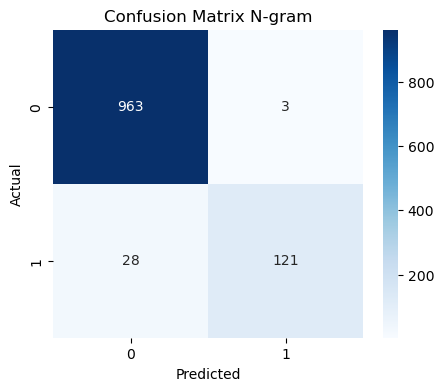

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_ng = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix N-gram")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [200]:
bow = CountVectorizer(ngram_range=(1,2), min_df=2)
X_train = bow.fit_transform(train["message"])
X_test  = bow.transform(test["message"])
y_train = train["label"]
y_test  = test["label"]

In [201]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

In [202]:
rf.fit(X_train, y_train)
print("RF OOB Score:", rf.oob_score_)

RF OOB Score: 0.979582678932017


In [203]:
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test accuracy: {acc_rf:.4f}\n\n")
print("Random Forest Classification Report:\n",
      classification_report(y_test, y_pred_rf, target_names=["ham","spam"]))

Test accuracy: 0.9731


Random Forest Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



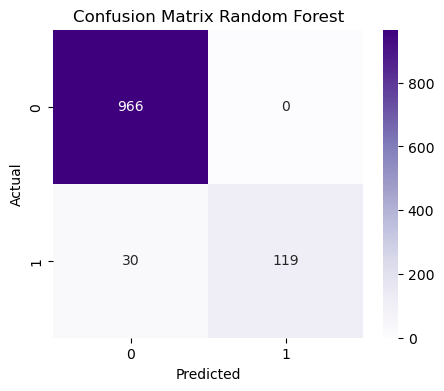

In [204]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()